In [1]:
# Test the tool on single-cell rnaseq data from bone marrow 

In [2]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

In [3]:
data_importer = flexynesis.DataImporter(path ='/data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/', 
                                        data_types = ['RNA', 'ADT'], 
                                        concatenate=False, top_percentile=1, min_features=25)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/train/clin.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/train/RNA.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/train/ADT.csv...

[INFO] ----------------- Reading Data -----------------
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/test/clin.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/test/RNA.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/benchmarks/single_cell/singlecell_bonemarrow/test/ADT.csv...

[INFO] ---------- Processing Data (tr

Calculating Laplacian scores: 100%|██████████| 16698/16698 [01:04<00:00, 257.52it/s]
Removing redundant features among top scoring ones: 100%|██████████| 1835/1835 [00:01<00:00, 1598.33it/s]


Implementing feature selection using laplacian score for layer: ADT with  25 features
Returning original matrix, demanded # of features is  larger than existing number of features

[INFO] ---------- Processing Data (test) ----------

[INFO] --------------- Cleaning Up Data ---------------
Number of NA values:  0
[INFO] DataFrame RNA - Removed 316 features.
Number of NA values:  0
[INFO] DataFrame ADT - Removed 0 features.
DataFrame RNA - Removed 0 samples (0.00%).
DataFrame ADT - Removed 0 samples (0.00%).

[INFO] ------------ Harmonizing Data Sets ------------

[INFO] --------------- Normalizing Data ---------------

[INFO] --------------- Normalizing Data ---------------
[INFO] Data import successful.


In [4]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: nCount_RNA
Numerical Variable Summary: Median = 2280.0, Mean = 2927.5772
------
Summary for variable: nFeature_RNA
Numerical Variable Summary: Median = 762.0, Mean = 883.229
------
Summary for variable: nCount_ADT
Numerical Variable Summary: Median = 4449.5, Mean = 4545.3088
------
Summary for variable: nFeature_ADT
Numerical Variable Summary: Median = 25.0, Mean = 24.8738
------
Summary for variable: RNA_weight
Numerical Variable Summary: Median = 0.405137738168857, Mean = 0.39226083495690867
------
Summary for variable: orig_ident
Categorical Variable Summary:
  Label: bmcite, Count: 5000
------
Summary for variable: lane
Categorical Variable Summary:
  Label: HumanHTO1, Count: 466
  Label: HumanHTO10, Count: 466
  Label: HumanHTO2, Count: 505
  Label: HumanHTO3, Count: 523
  Label: HumanHTO4, Count: 381
  Label: HumanHTO5, Count: 508
  Label: HumanHTO6, Count: 523
  Label: HumanHTO7, Count: 596
  Label: HumanHTO8, Count: 545
  Label: HumanHTO9, Count: 487
-----

In [5]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = "celltype_l2",
                                        config_name = "DirectPred", 
                                        config_path='./conf.yaml',
                                        plot_losses=True, early_stop_patience=20, 
                                        n_iter=20)    

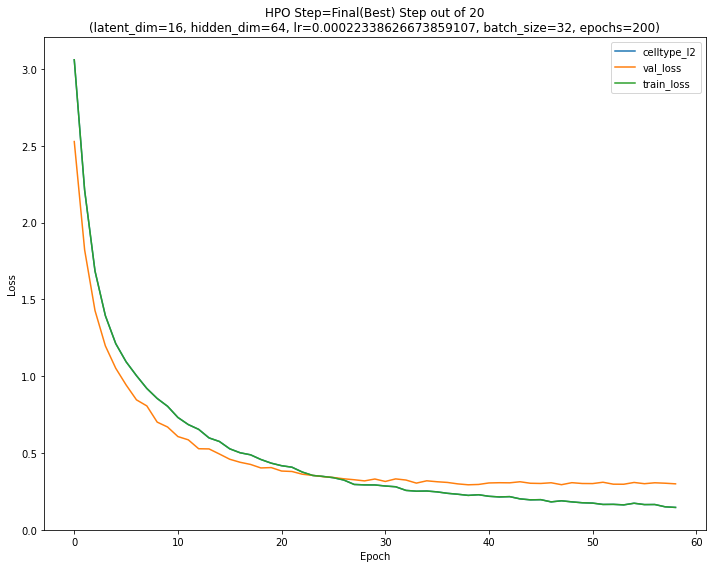

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.293. Signaling Trainer to stop.


In [6]:
model, best_params = tuner.perform_tuning()

In [7]:
model

DirectPred(
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=165, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=16, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=25, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=16, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (celltype_l2): MLP(
      (layer_1): Linear(in_features=32, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=27, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=

In [8]:
best_params

{'latent_dim': 16,
 'hidden_dim': 64,
 'lr': 0.00022338626673859107,
 'batch_size': 32,
 'epochs': 200}

In [9]:
y_pred_dict = model.predict(test_dataset)

In [10]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

Balanced Accuracy: 0.7822
F1 Score (Macro): 0.8030
Cohen's Kappa: 0.9051

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1067
         1.0       1.00      0.98      0.99        56
         2.0       0.95      0.92      0.94       575
         3.0       0.93      0.99      0.96       725
         4.0       0.94      0.80      0.86        20
         5.0       0.90      0.85      0.87        94
         6.0       0.92      0.79      0.85        58
         7.0       0.82      0.79      0.81        63
         8.0       0.88      0.89      0.88        88
         9.0       0.97      1.00      0.98       644
        10.0       0.70      0.76      0.72       115
        11.0       0.57      0.68      0.62        37
        12.0       0.46      0.56      0.51        43
        13.0       0.86      0.96      0.91        98
        14.0       0.89      0.85      0.87       249
        15.0       0.99      0.98     

,var,variable_type,metric,value
0,celltype_l2,categorical,balanced_acc,0.782167
1,celltype_l2,categorical,f1_score,0.802974
2,celltype_l2,categorical,kappa,0.905092


In [11]:
ds = test_dataset
E = model.transform(ds)

In [12]:
f = 'celltype_l2'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

In [ ]:
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':50, 'alpha': 0.8},legend_kwargs={'fontsize': 15}, figsize=(12, 12))

In [ ]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 50)

In [ ]:
top_features = flexynesis.get_important_features(model, f, top=2)

In [ ]:
my_dict = train_dataset.label_mappings['celltype_l2']
my_list = top_features['target_class']
top_features['target_class_label'] = [my_dict.get(item) for item in my_list if item in my_dict]
top_features

In [79]:
list(top_features[top_features['target_class']==4]['name'])

['RPS27', 'CD2', 'CTSS', 'AAK1', 'FCER1G']

In [61]:
train_dataset.label_mappings['celltype_l1']

{0: 'B cell', 1: 'Mono/DC', 2: 'NK', 3: 'Progenitor cells', 4: 'T cell'}

In [57]:
import numpy as np 
tf = top_features.groupby('layer')['name'].apply(list).to_dict()
tf = {x: np.unique(tf[x]) for x in tf.keys()} # get unique sets per layer

In [58]:
df = flexynesis.subset_assays_by_features(ds, tf)

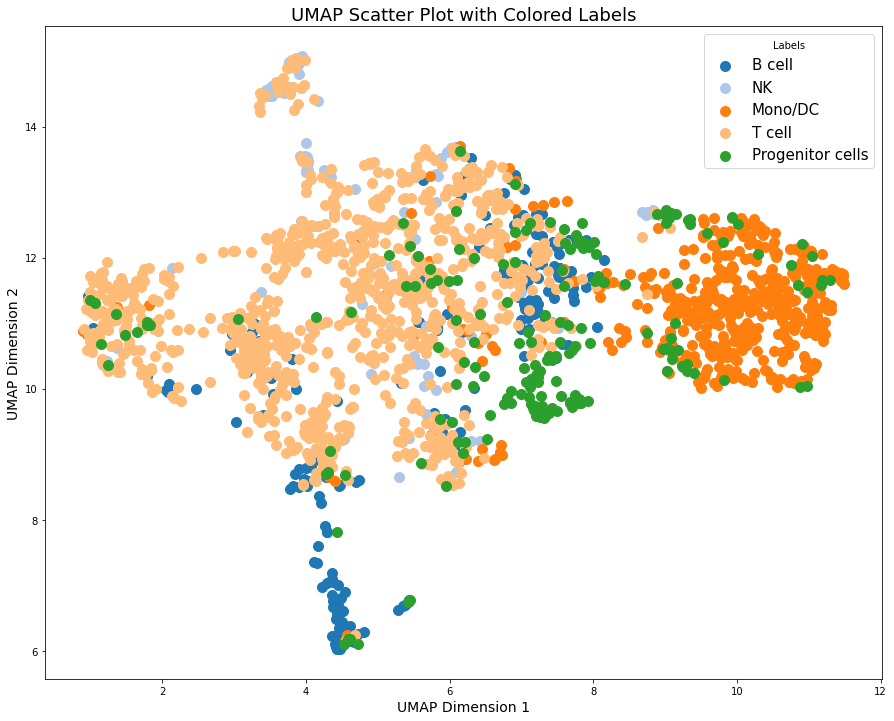

In [59]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='umap', scatter_kwargs={'s':100}, legend_kwargs={'fontsize': 15}, figsize=(15, 12))